## Modelo de Previsão de Inadimplência
Nesse projeto, faremos um modelo de previsão de inadimplência de empréstimos imobiliários.
- **Fonte de Dados:** SQL Server
- **Modelo Selecionado:** Random Forest
- **Entrega Final:** Dashboard Power BI com análise completa do perfil inadimplente + API Streamlit para fazer novas previsões

### Importação das bibliotecas necessárias

In [2]:
# Imports
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import time
import numpy as np
import joblib # para salvar o modelo preditivo
from sklearn.preprocessing import LabelEncoder # para fazer o OneHotEncoding
from sklearn.metrics import mean_squared_error, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE # fazer o balanceamento
from sklearn.preprocessing import MinMaxScaler # fazer a padronização
from sklearn.metrics import r2_score # medir a acurácia
import pyodbc

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Importando dados do SQL Server

In [3]:
# Importando dados

# Criando conexão com SQL Server
conexao = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=DESKTOP-CR5F8QN;'
    'DATABASE=MODELOS_PREDITIVOS;'
    'Trusted_Connection=yes;'
    'TrustServerCertificate=yes;'
)

# Consulta ao banco de dados
df = pd.read_sql_query('SELECT * FROM EXTRACAO_DADOS_SISTEMA', conexao)

# Fechando conexão
conexao.close()

### Análise Exploratória dos Dados
Vamos analisar o conjunto de dados: visão geral, informações estatísticas, tipo e período dos dados

In [4]:
# Visualização
df.head()

,NUMERO_CONTRATO,DATA_ASSINATURA_CONTRATO,TIPO_FINANCIAMENTO,TAXA_AO_ANO,PZ_FINANCIAMENTO,CIDADE_CLIENTE,ESTADO_CLIENTE,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_FINANCIAMENTO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO,INADIMPLENTE_COBRANCA
0,41637,2012-03-23,IMOBILIARIO,15.0,180,FORTALEZA,CE,4800.0,0,0,97,120078.00,72,3,506,152,73767.0,471.29,70.0,SIM
1,67958,2012-01-24,IMOBILIARIO,15.0,200,SAO PAULO,SP,6800.0,0,0,103,156759.47,42,1,349,93,323251.0,1858.69,28.0,SIM
2,68502,2014-05-23,IMOBILIARIO,18.0,200,SAO PAULO,SP,6800.0,0,0,98,277125.05,83,1,151,39,529419.0,3123.57,60.0,SIM
3,68731,2015-10-23,IMOBILIARIO,15.0,200,SAO PAULO,SP,6800.0,0,0,87,351395.19,66,1,3797,206,499753.0,2873.58,41.0,SIM
4,68996,2017-01-24,IMOBILIARIO,17.0,200,SAO PAULO,SP,6800.0,0,0,71,344249.83,57,1,36,10,722057.0,4224.03,63.0,SIM


In [5]:
# Tamanho
df.shape

(10415, 20)

In [6]:
# Tipo dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10415 entries, 0 to 10414
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   NUMERO_CONTRATO                 10415 non-null  int64  
 1   DATA_ASSINATURA_CONTRATO        10415 non-null  object 
 2   TIPO_FINANCIAMENTO              10415 non-null  object 
 3   TAXA_AO_ANO                     10415 non-null  float64
 4   PZ_FINANCIAMENTO                10415 non-null  int64  
 5   CIDADE_CLIENTE                  10415 non-null  object 
 6   ESTADO_CLIENTE                  10415 non-null  object 
 7   RENDA_MENSAL_CLIENTE            10415 non-null  float64
 8   QT_PC_ATRASO                    10415 non-null  int64  
 9   QT_DIAS_PRIM_PC_ATRASO          10415 non-null  int64  
 10  QT_TOTAL_PC_PAGAS               10415 non-null  int64  
 11  VL_TOTAL_PC_PAGAS               10411 non-null  float64
 12  QT_PC_PAGA_EM_DIA               

In [7]:
# Informações estatísticas
df.describe()

,NUMERO_CONTRATO,TAXA_AO_ANO,PZ_FINANCIAMENTO,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_FINANCIAMENTO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO
count,10415.000000,10415.000000,10415.000000,10415.000000,10415.000000,10415.000000,10415.000000,10411.000000,10415.000000,10415.000000,10415.000000,10415.000000,1.041500e+04,10415.000000,10414.000000
mean,95569.356889,17.271483,114.242535,5620.259241,16.716179,664.389438,35.946711,44528.545631,27.667115,6.115699,79.133845,28.841863,3.255909e+05,3617.341097,40.789418
std,34561.658949,2.566596,64.330109,2930.301113,30.706681,1181.352716,28.384415,65640.970502,25.153443,82.908021,334.871089,137.395374,1.774775e+05,1932.714754,12.390906
min,32709.000000,7.000000,48.000000,1800.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,2.932700e+04,185.740000,0.000000
25%,75868.500000,16.000000,72.000000,1800.000000,0.000000,0.000000,11.000000,8675.445000,7.000000,0.000000,0.000000,0.000000,2.100000e+05,2467.755000,31.250000
50%,79111.000000,17.000000,72.000000,7800.000000,0.000000,0.000000,33.000000,24345.600000,22.000000,1.000000,8.000000,4.000000,2.800000e+05,3470.590000,39.000000
75%,136637.500000,19.000000,180.000000,7800.000000,22.000000,1005.500000,54.000000,46787.290000,42.000000,3.000000,62.000000,22.000000,3.929738e+05,4930.245000,49.000000
max,155890.000000,25.500000,240.000000,9800.000000,178.000000,5655.000000,167.000000,714499.740000,136.000000,5465.000000,5710.000000,5480.000000,1.400000e+06,14410.000000,118.000000


In [8]:
# Valores nulos
# Como há apenas 5 valores nulos, eles serão excluídos na fase de tratamento dos dados
df.isnull().sum()

NUMERO_CONTRATO                   0
DATA_ASSINATURA_CONTRATO          0
TIPO_FINANCIAMENTO                0
TAXA_AO_ANO                       0
PZ_FINANCIAMENTO                  0
CIDADE_CLIENTE                    0
ESTADO_CLIENTE                    0
RENDA_MENSAL_CLIENTE              0
QT_PC_ATRASO                      0
QT_DIAS_PRIM_PC_ATRASO            0
QT_TOTAL_PC_PAGAS                 0
VL_TOTAL_PC_PAGAS                 4
QT_PC_PAGA_EM_DIA                 0
QT_DIAS_MIN_ATRASO                0
QT_DIAS_MAX_ATRASO                0
QT_DIAS_MEDIA_ATRASO              0
VALOR_FINANCIAMENTO               0
VALOR_PARCELA                     0
IDADE_DATA_ASSINATURA_CONTRATO    1
INADIMPLENTE_COBRANCA             0
dtype: int64

In [9]:
# Valores duplicados
# Não há valores duplicados
df.duplicated().sum()

0

In [10]:
# Período dos dados
inicio = pd.to_datetime(df['DATA_ASSINATURA_CONTRATO']).dt.date.min()
fim = pd.to_datetime(df['DATA_ASSINATURA_CONTRATO']).dt.date.max()
print('Período dos dados:', inicio,'a',fim)

Período dos dados: 2012-01-10 a 2022-11-14


In [11]:
# Valores únicos por variável
var_unicos = []
for i in df.columns[0:20].tolist():
    print(i, ':', len(df[i].astype(str).value_counts()))
    var_unicos.append(len(df[i].astype(str).value_counts()))

NUMERO_CONTRATO : 10415
DATA_ASSINATURA_CONTRATO : 1070
TIPO_FINANCIAMENTO : 1
TAXA_AO_ANO : 111
PZ_FINANCIAMENTO : 9
CIDADE_CLIENTE : 525
ESTADO_CLIENTE : 27
RENDA_MENSAL_CLIENTE : 7
QT_PC_ATRASO : 130
QT_DIAS_PRIM_PC_ATRASO : 227
QT_TOTAL_PC_PAGAS : 137
VL_TOTAL_PC_PAGAS : 9861
QT_PC_PAGA_EM_DIA : 129
QT_DIAS_MIN_ATRASO : 122
QT_DIAS_MAX_ATRASO : 534
QT_DIAS_MEDIA_ATRASO : 323
VALOR_FINANCIAMENTO : 834
VALOR_PARCELA : 1826
IDADE_DATA_ASSINATURA_CONTRATO : 79
INADIMPLENTE_COBRANCA : 2


In [12]:
# Valores mínimo e máximo de VALOR_FINANCIAMENTO
print('Valor mínimo:', df['VALOR_FINANCIAMENTO'].min())
print('Valor máximo:', df['VALOR_FINANCIAMENTO'].max())

Valor mínimo: 29327.0
Valor máximo: 1400000.0


In [13]:
# Exclusão de valores nulos
# Como há apenas 5 valores nulos, vamos excluí-los, pois não terá impacto nos dados, dado o tamanho do dataframe
df.dropna(inplace=True)

### Avaliando os tipos de dados nas variáveis
Aplicaremos groupby para analisar o total de cada tipo de informação nas variáveis

In [14]:
# Se inadimplente (variável target)
df.groupby(['INADIMPLENTE_COBRANCA']).size()

INADIMPLENTE_COBRANCA
NAO    2375
SIM    8035
dtype: int64

In [15]:
# Prazo do refinanciamento
df.groupby(['PZ_FINANCIAMENTO']).size()

PZ_FINANCIAMENTO
48      343
72     6121
100     938
160       2
180     765
194       2
200     558
220     773
240     908
dtype: int64

In [16]:
# Renda mensal
df.groupby(['RENDA_MENSAL_CLIENTE']).size()

RENDA_MENSAL_CLIENTE
1800.0    3511
3800.0      33
4800.0     416
5800.0    1038
6800.0     130
7800.0    4303
9800.0     979
dtype: int64

### Engenharia de Atributos
Criando faixas de valor para prazo de financiamento e valor de financiamento

In [17]:
# Criando faixa de prazos
bins = [-1, 120, 180, 240]
labels = ['Até 120 meses', '121 até 180 meses', '181 até 240 meses']
df['FAIXA_PRAZO_FINANCIAMENTO'] = pd.cut(df['PZ_FINANCIAMENTO'], bins=bins, labels=labels)
pd.value_counts(df.FAIXA_PRAZO_FINANCIAMENTO)

FAIXA_PRAZO_FINANCIAMENTO
Até 120 meses        7402
181 até 240 meses    2241
121 até 180 meses     767
Name: count, dtype: int64

In [18]:
# Criando faixa de valor financiado
bins = [-1, 100000, 200000, 300000, 400000, 500000, 750000, 1000000, 900000000]
labels = ['Até 100 mil', '101 até 200 mil', '201 até 300 mil', '301 até 400 mil',
          '401 até 500 mil', '501 até 750 mil', '750 mil até 1 milhão', 'Acima de 1 milhão']
df['FAIXA_VALOR_FINANCIADO'] = pd.cut(df['VALOR_FINANCIAMENTO'], bins=bins, labels=labels)
pd.value_counts(df.FAIXA_VALOR_FINANCIADO)

FAIXA_VALOR_FINANCIADO
201 até 300 mil         3949
301 até 400 mil         2098
101 até 200 mil         1823
401 até 500 mil         1128
501 até 750 mil          915
750 mil até 1 milhão     236
Até 100 mil              167
Acima de 1 milhão         94
Name: count, dtype: int64

### Selecionando variáveis que iremos utilizar
Vamos criar um novo dataframe apenas com as variáveis que iremos utilizar em nosso modelo. Descartaremos:
* TIPO_FINANCIAMENTO (só há 1 tipo)
* VALOR_FINANCIAMENTO E PRAZO FINANCIAMENTO (usaremos as faixas de valor criadas com base nessas variáveis)
* NUMERO_CONTRATO e DATA_ASSINATURA_CONTRATO (não serão últeis para nosso modelo preditivo)

In [19]:
# Selecionando colunas
columns = ['TAXA_AO_ANO', 'CIDADE_CLIENTE', 'ESTADO_CLIENTE','RENDA_MENSAL_CLIENTE', 
           'QT_PC_ATRASO', 'QT_DIAS_PRIM_PC_ATRASO','QT_TOTAL_PC_PAGAS',
           'VL_TOTAL_PC_PAGAS', 'QT_PC_PAGA_EM_DIA','QT_DIAS_MIN_ATRASO',
           'QT_DIAS_MAX_ATRASO', 'QT_DIAS_MEDIA_ATRASO','VALOR_PARCELA',
           'IDADE_DATA_ASSINATURA_CONTRATO', 'FAIXA_VALOR_FINANCIADO',
           'FAIXA_PRAZO_FINANCIAMENTO','INADIMPLENTE_COBRANCA']

df_tratado = pd.DataFrame(df, columns=columns)

In [20]:
# Visualização
df_tratado.head()

,TAXA_AO_ANO,CIDADE_CLIENTE,ESTADO_CLIENTE,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO,FAIXA_VALOR_FINANCIADO,FAIXA_PRAZO_FINANCIAMENTO,INADIMPLENTE_COBRANCA
0,15.0,FORTALEZA,CE,4800.0,0,0,97,120078.00,72,3,506,152,471.29,70.0,Até 100 mil,121 até 180 meses,SIM
1,15.0,SAO PAULO,SP,6800.0,0,0,103,156759.47,42,1,349,93,1858.69,28.0,301 até 400 mil,181 até 240 meses,SIM
2,18.0,SAO PAULO,SP,6800.0,0,0,98,277125.05,83,1,151,39,3123.57,60.0,501 até 750 mil,181 até 240 meses,SIM
3,15.0,SAO PAULO,SP,6800.0,0,0,87,351395.19,66,1,3797,206,2873.58,41.0,401 até 500 mil,181 até 240 meses,SIM
4,17.0,SAO PAULO,SP,6800.0,0,0,71,344249.83,57,1,36,10,4224.03,63.0,501 até 750 mil,181 até 240 meses,SIM


In [21]:
# Tamanho
df_tratado.shape

(10410, 17)

In [22]:
# Tipo dos dados
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10410 entries, 0 to 10414
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   TAXA_AO_ANO                     10410 non-null  float64 
 1   CIDADE_CLIENTE                  10410 non-null  object  
 2   ESTADO_CLIENTE                  10410 non-null  object  
 3   RENDA_MENSAL_CLIENTE            10410 non-null  float64 
 4   QT_PC_ATRASO                    10410 non-null  int64   
 5   QT_DIAS_PRIM_PC_ATRASO          10410 non-null  int64   
 6   QT_TOTAL_PC_PAGAS               10410 non-null  int64   
 7   VL_TOTAL_PC_PAGAS               10410 non-null  float64 
 8   QT_PC_PAGA_EM_DIA               10410 non-null  int64   
 9   QT_DIAS_MIN_ATRASO              10410 non-null  int64   
 10  QT_DIAS_MAX_ATRASO              10410 non-null  int64   
 11  QT_DIAS_MEDIA_ATRASO            10410 non-null  int64   
 12  VALOR_PARCELA          

In [23]:
# Se há nulos
df_tratado.isnull().sum()

TAXA_AO_ANO                       0
CIDADE_CLIENTE                    0
ESTADO_CLIENTE                    0
RENDA_MENSAL_CLIENTE              0
QT_PC_ATRASO                      0
QT_DIAS_PRIM_PC_ATRASO            0
QT_TOTAL_PC_PAGAS                 0
VL_TOTAL_PC_PAGAS                 0
QT_PC_PAGA_EM_DIA                 0
QT_DIAS_MIN_ATRASO                0
QT_DIAS_MAX_ATRASO                0
QT_DIAS_MEDIA_ATRASO              0
VALOR_PARCELA                     0
IDADE_DATA_ASSINATURA_CONTRATO    0
FAIXA_VALOR_FINANCIADO            0
FAIXA_PRAZO_FINANCIAMENTO         0
INADIMPLENTE_COBRANCA             0
dtype: int64

### Análise Exploratória das Variáveis Categóricas
Objetivos:
* Entender a relação das variáveis categóricas com a variável target
* Identificar que variáveis categóricas iremos manter ou descartar para nosso modelo

<Axes: title={'center': 'Inadimplentes'}, xlabel='INADIMPLENTE_COBRANCA'>

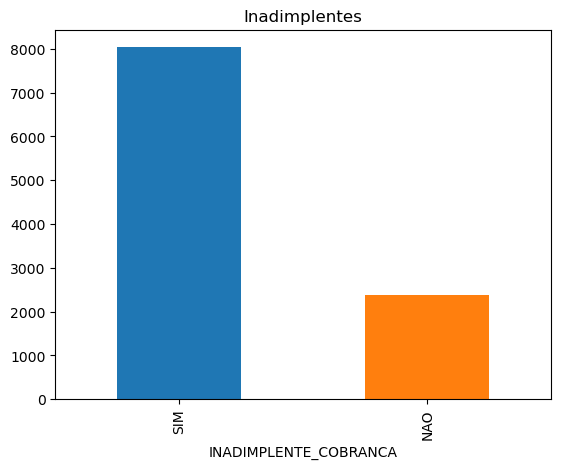

In [24]:
# Análise visual da variável target (precisa de balanceamento)
df_tratado.INADIMPLENTE_COBRANCA.value_counts().plot(kind='bar', title='Inadimplentes', color=['#1F77B4', '#FF7F0E'])

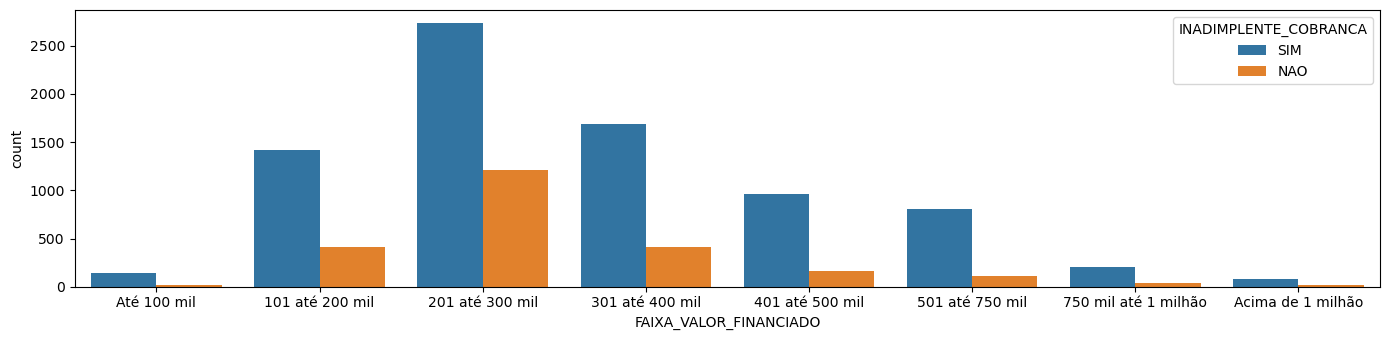

In [25]:
# Faixa de Valor Financiado x Inadimplência
plt.rcParams['figure.figsize'] = [14.00, 3.50]
plt.rcParams['figure.autolayout'] = True
sns.countplot(data=df_tratado, x='FAIXA_VALOR_FINANCIADO', hue='INADIMPLENTE_COBRANCA')
plt.show()

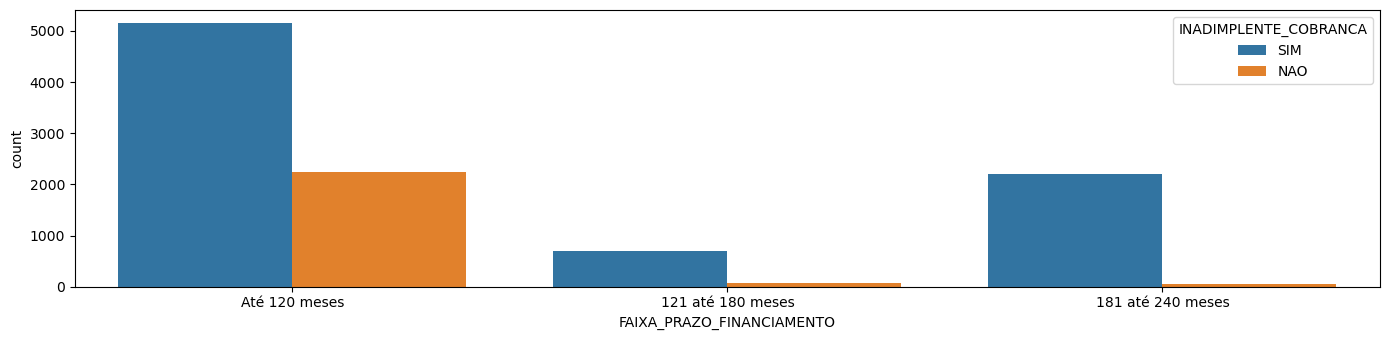

In [26]:
# Faixa de Prazo do Financiamento x Inadimplência
plt.rcParams['figure.figsize'] = [14.00, 3.50]
plt.rcParams['figure.autolayout'] = True
sns.countplot(data=df_tratado, x='FAIXA_PRAZO_FINANCIAMENTO', hue='INADIMPLENTE_COBRANCA')
plt.show()

### Análise Exploratória das Variáveis Numéricas
Objetivos:
* Entender a relação das variáveis numéricas com a variável target
* Fazer uma análise estatística (média, moda, mediana, desvio padrão, identificação de outliers)

In [27]:
# Verificando o tipo
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10410 entries, 0 to 10414
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   TAXA_AO_ANO                     10410 non-null  float64 
 1   CIDADE_CLIENTE                  10410 non-null  object  
 2   ESTADO_CLIENTE                  10410 non-null  object  
 3   RENDA_MENSAL_CLIENTE            10410 non-null  float64 
 4   QT_PC_ATRASO                    10410 non-null  int64   
 5   QT_DIAS_PRIM_PC_ATRASO          10410 non-null  int64   
 6   QT_TOTAL_PC_PAGAS               10410 non-null  int64   
 7   VL_TOTAL_PC_PAGAS               10410 non-null  float64 
 8   QT_PC_PAGA_EM_DIA               10410 non-null  int64   
 9   QT_DIAS_MIN_ATRASO              10410 non-null  int64   
 10  QT_DIAS_MAX_ATRASO              10410 non-null  int64   
 11  QT_DIAS_MEDIA_ATRASO            10410 non-null  int64   
 12  VALOR_PARCELA          

In [28]:
# Gerando lista com as variáveis
var_numericas = []
for i in df_tratado.columns[0:17].tolist():
    if df_tratado.dtypes[i] == 'int64' or df_tratado.dtypes[i] == 'float64':
        var_numericas.append(i)

# Visualizando as variáveis numéricas
var_numericas

['TAXA_AO_ANO',
 'RENDA_MENSAL_CLIENTE',
 'QT_PC_ATRASO',
 'QT_DIAS_PRIM_PC_ATRASO',
 'QT_TOTAL_PC_PAGAS',
 'VL_TOTAL_PC_PAGAS',
 'QT_PC_PAGA_EM_DIA',
 'QT_DIAS_MIN_ATRASO',
 'QT_DIAS_MAX_ATRASO',
 'QT_DIAS_MEDIA_ATRASO',
 'VALOR_PARCELA',
 'IDADE_DATA_ASSINATURA_CONTRATO']

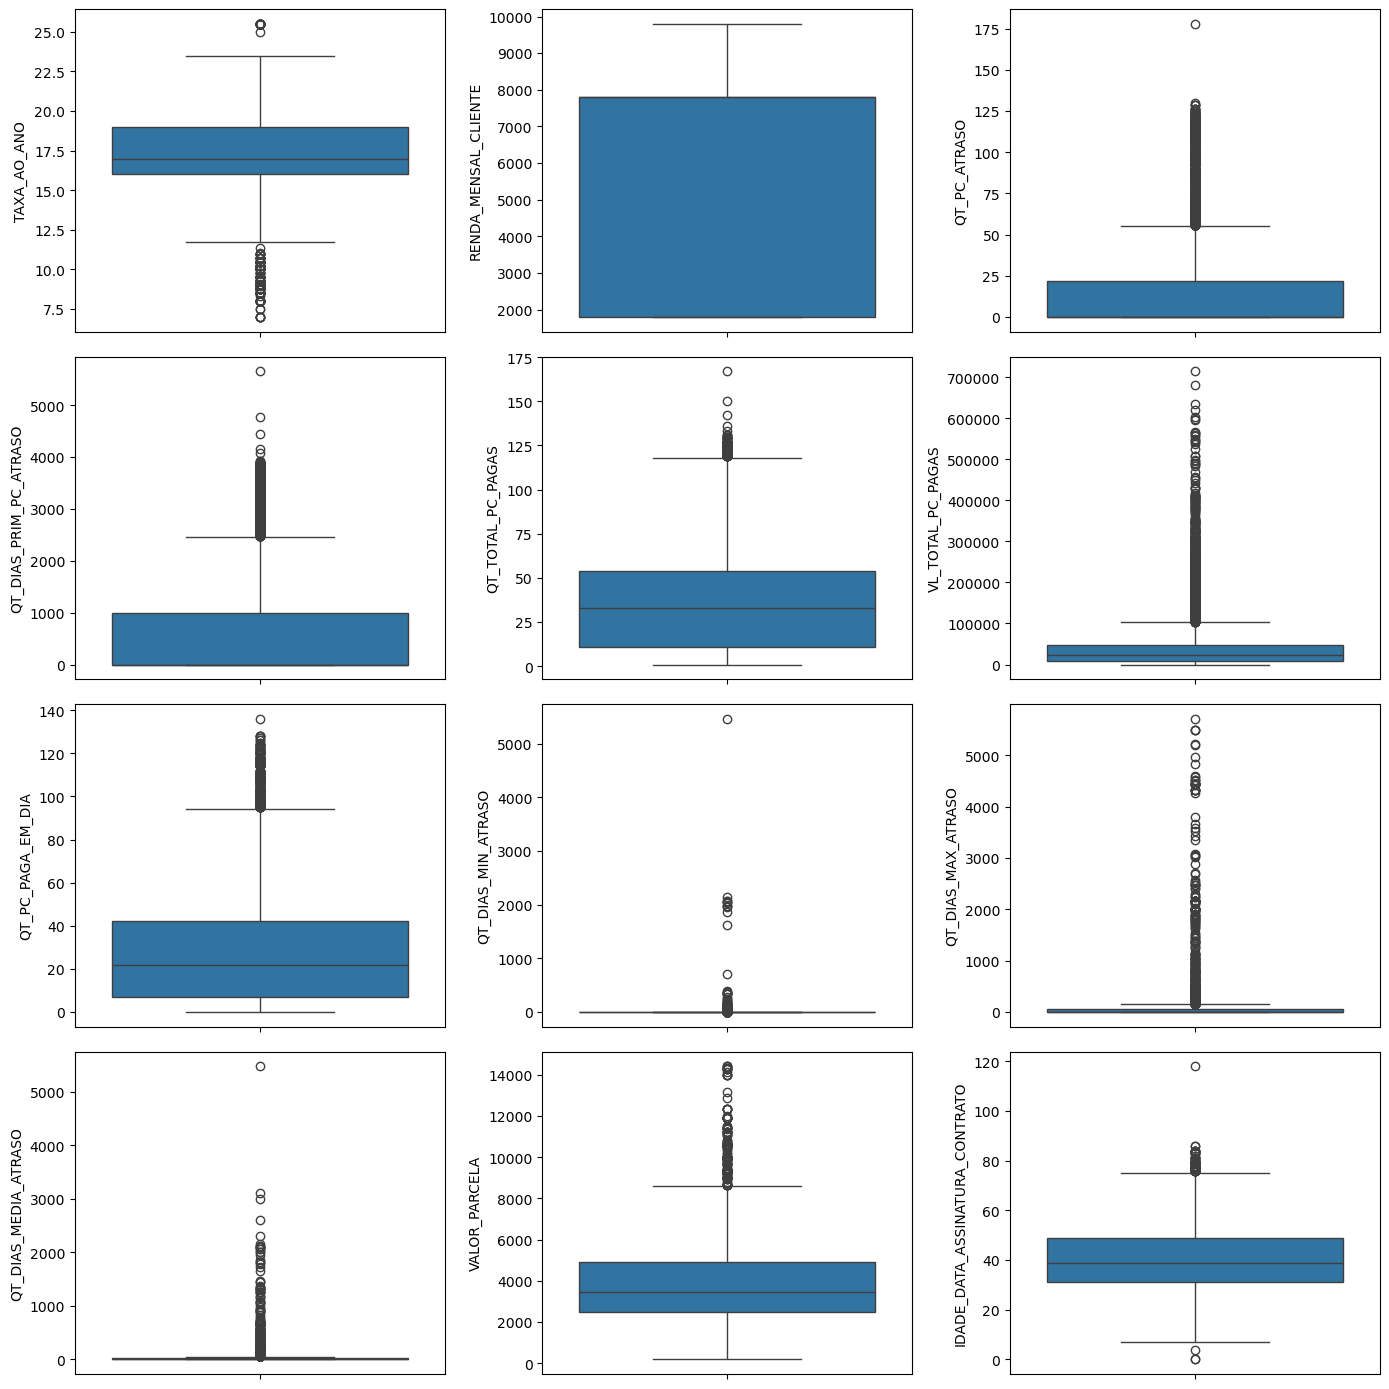

In [29]:
# Gerando boxplot
# Dado o contexto dos dados, não há outliers nas variáveis numéricas. Elas apresentam sim extremos, mas estão de acordo com o contexto.
plt.rcParams['figure.figsize'] = [14.00, 14.00]
plt.rcParams['figure.autolayout'] = True
f, axes = plt.subplots(4,3)

linha = 0
coluna = 0
for i in var_numericas:
    sns.boxplot(data = df_tratado, y=i, ax=axes[linha][coluna])
    coluna +=1
    if coluna == 3:
        linha +=1
        coluna = 0

plt.show()

### Convertendo as variáveis categóricas para variáveis numéricas

In [30]:
# Carregando as variáveis categóricas para OneHotEncoding (exceto a variável target)
var_categoricas = []
for i in df_tratado.columns[0:16].tolist():
    if df_tratado.dtypes[i] == 'object' or df_tratado.dtypes[i] == 'category':
        var_categoricas.append(i)

In [31]:
# Visualizando variáveis
var_categoricas

['CIDADE_CLIENTE',
 'ESTADO_CLIENTE',
 'FAIXA_VALOR_FINANCIADO',
 'FAIXA_PRAZO_FINANCIAMENTO']

In [32]:
# Criando o encoder e aplicando o OneHotEncoder
lb = LabelEncoder()

for var in var_categoricas:
    df_tratado[var] = lb.fit_transform(df_tratado[var])

In [33]:
# Visualizando dados
df_tratado.head()

,TAXA_AO_ANO,CIDADE_CLIENTE,ESTADO_CLIENTE,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO,FAIXA_VALOR_FINANCIADO,FAIXA_PRAZO_FINANCIAMENTO,INADIMPLENTE_COBRANCA
0,15.0,152,5,4800.0,0,0,97,120078.00,72,3,506,152,471.29,70.0,7,0,SIM
1,15.0,453,25,6800.0,0,0,103,156759.47,42,1,349,93,1858.69,28.0,2,1,SIM
2,18.0,453,25,6800.0,0,0,98,277125.05,83,1,151,39,3123.57,60.0,4,1,SIM
3,15.0,453,25,6800.0,0,0,87,351395.19,66,1,3797,206,2873.58,41.0,3,1,SIM
4,17.0,453,25,6800.0,0,0,71,344249.83,57,1,36,10,4224.03,63.0,4,1,SIM


In [34]:
# Verificando tipos
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10410 entries, 0 to 10414
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   TAXA_AO_ANO                     10410 non-null  float64
 1   CIDADE_CLIENTE                  10410 non-null  int32  
 2   ESTADO_CLIENTE                  10410 non-null  int32  
 3   RENDA_MENSAL_CLIENTE            10410 non-null  float64
 4   QT_PC_ATRASO                    10410 non-null  int64  
 5   QT_DIAS_PRIM_PC_ATRASO          10410 non-null  int64  
 6   QT_TOTAL_PC_PAGAS               10410 non-null  int64  
 7   VL_TOTAL_PC_PAGAS               10410 non-null  float64
 8   QT_PC_PAGA_EM_DIA               10410 non-null  int64  
 9   QT_DIAS_MIN_ATRASO              10410 non-null  int64  
 10  QT_DIAS_MAX_ATRASO              10410 non-null  int64  
 11  QT_DIAS_MEDIA_ATRASO            10410 non-null  int64  
 12  VALOR_PARCELA                   10410

### Separando variáveis em preditoras e target

In [35]:
# Visualizando a variável target para balanceamento
var_target = df_tratado.INADIMPLENTE_COBRANCA.value_counts()
var_target

INADIMPLENTE_COBRANCA
SIM    8035
NAO    2375
Name: count, dtype: int64

In [36]:
# Separar variáveis preditoras e target
PREDITORAS = df_tratado.iloc[:, 0:15]
TARGET = df_tratado.iloc[:, 16]

In [37]:
# Visualizando as variáveis preditoras
PREDITORAS.head()

,TAXA_AO_ANO,CIDADE_CLIENTE,ESTADO_CLIENTE,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO,FAIXA_VALOR_FINANCIADO
0,15.0,152,5,4800.0,0,0,97,120078.00,72,3,506,152,471.29,70.0,7
1,15.0,453,25,6800.0,0,0,103,156759.47,42,1,349,93,1858.69,28.0,2
2,18.0,453,25,6800.0,0,0,98,277125.05,83,1,151,39,3123.57,60.0,4
3,15.0,453,25,6800.0,0,0,87,351395.19,66,1,3797,206,2873.58,41.0,3
4,17.0,453,25,6800.0,0,0,71,344249.83,57,1,36,10,4224.03,63.0,4


In [38]:
# Visualizando a variável target
TARGET.head()

0    SIM
1    SIM
2    SIM
3    SIM
4    SIM
Name: INADIMPLENTE_COBRANCA, dtype: object

### Balanceamento das Variáveis

In [39]:
# Para reproduzir o mesmo resultado
seed = 100

# Criando o balanceador SMOTE
balanceador = SMOTE(random_state = seed)

# Aplicando o balanceador
PREDITORA_RES, TARGET_RES = balanceador.fit_resample(PREDITORAS, TARGET)

<Axes: title={'center': 'Inadimplentes X Não Inadimplentes'}, xlabel='INADIMPLENTE_COBRANCA'>

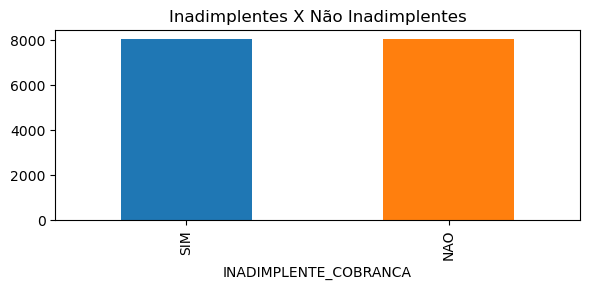

In [40]:
# Visualizando o balanceamento da target
plt.rcParams['figure.figsize'] = [6.00, 3.00]
plt.rcParams['figure.autolayout'] = True
TARGET_RES.value_counts().plot(kind='bar', title='Inadimplentes X Não Inadimplentes', color=['#1F77B4', '#FF7F0E'])

In [41]:
# Preditoras antes do balanceamento
PREDITORAS.shape

(10410, 15)

In [42]:
# Target antes do balanceamento
TARGET.shape

(10410,)

In [43]:
# Preditoras depois do balanceamento
PREDITORA_RES.shape

(16070, 15)

In [44]:
# Target depois do balanceamento
TARGET_RES.shape

(16070,)

In [45]:
# Divisão dos dados em treino e teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(PREDITORA_RES, TARGET_RES, test_size=0.3, random_state=42)

### Normalização das Variáveis

In [46]:
# Normalizando as variáveis
normalizador = MinMaxScaler()
X_treino_normalizado = normalizador.fit_transform(X_treino)
X_teste_normalizado = normalizador.transform(X_teste)

In [47]:
# Visualizando os dados de treino normalizados
X_treino_normalizado

array([[0.45945946, 0.03816794, 0.15384615, ..., 0.50322829, 0.22033898,
        0.57142857],
       [0.66904491, 0.12977099, 0.23076923, ..., 0.40839172, 0.41221454,
        0.42857143],
       [0.59459459, 0.3110687 , 0.30769231, ..., 0.03970892, 0.25423729,
        0.        ],
       ...,
       [0.10810811, 0.3110687 , 0.30769231, ..., 0.16001324, 0.34745763,
        0.        ],
       [0.64864865, 0.86450382, 0.96153846, ..., 0.23265885, 0.44444926,
        0.14285714],
       [0.42432432, 0.10305344, 0.38461538, ..., 0.03852714, 0.3559322 ,
        0.        ]])

In [48]:
# Visualizando a dimensão dos dados de treino normalizados
X_treino_normalizado.shape

(11249, 15)

### Criando e Treinando o Modelo Preditivo

In [49]:
# Criando o classificador com Random Forest
clf = RandomForestClassifier(n_estimators=300)

# Construção do modelo
clf = clf.fit(X_treino_normalizado, Y_treino)

In [50]:
# Verificando a acurácia do modelo com dados de teste
scores = clf.score(X_teste_normalizado, Y_teste)
scores

0.9197261978842564

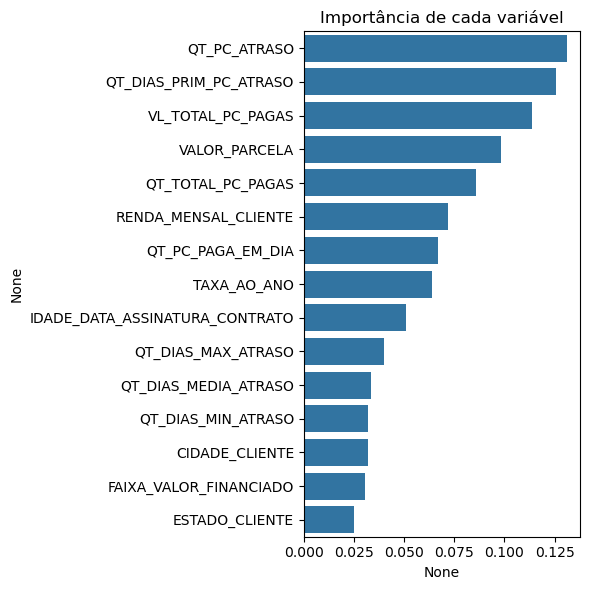

In [51]:
# Exibindo a importância de cada variável no modelo preditivo
plt.rcParams['figure.figsize'] = [6.00, 6.00]
plt.rcParams['figure.autolayout'] = True

importances = pd.Series(data=clf.feature_importances_, index=PREDITORAS.columns)
importances = importances.sort_values(ascending=False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada variável')

plt.show()

In [52]:
importances.sort_values(ascending=False)

QT_PC_ATRASO                      0.131067
QT_DIAS_PRIM_PC_ATRASO            0.125604
VL_TOTAL_PC_PAGAS                 0.113596
VALOR_PARCELA                     0.098095
QT_TOTAL_PC_PAGAS                 0.085918
RENDA_MENSAL_CLIENTE              0.071798
QT_PC_PAGA_EM_DIA                 0.067060
TAXA_AO_ANO                       0.063669
IDADE_DATA_ASSINATURA_CONTRATO    0.050829
QT_DIAS_MAX_ATRASO                0.039761
QT_DIAS_MEDIA_ATRASO              0.033362
QT_DIAS_MIN_ATRASO                0.031970
CIDADE_CLIENTE                    0.031863
FAIXA_VALOR_FINANCIADO            0.030442
ESTADO_CLIENTE                    0.024968
dtype: float64

In [53]:
# Salvando o modelo criado e treinado
joblib.dump(clf, 'modelo_treinado.pk')

['modelo_treinado.pk']